# Lição 7 - Filtros Colaborativos aplicado ao dataset *Book-Crossing: User review ratings*

## Objetivo

O Objetivo deste trabalho é a elaboração de um modelo de recomendação de livros baseado no dataset Book-Crossing: User Review Ratings por meio de filtros colaborativos.

## Autor

- Álvaro Gouvea - 180012002
- GitHub: AlGouvea

## Desenvolvimento

Importação dos módulos de filtros colaborativos e para tratar dados tabulares, além de definição de seed.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Depois de importar as bibliotecas necessárias passei a analisar o dataser que inclui informações de 278.858 usuários anônimos, mas com dados demograficos, que forneceram 1.149.780 classificações de 271.379 livros.
O dataset estava separado por *;* e não *,* então foi necessário explicitar esse delimitador, além de colocar o encoder *latin-1* por erro de interpretação de um byte pelo utf-8.

In [2]:
path = Path('../input/bookcrossing-dataset')
ratings = pd.read_csv(path/'Book reviews/Book reviews/BX-Book-Ratings.csv', encoding='latin-1', delimiter=';', usecols=(0,1,2), names=('user_id','isbn','rating'), low_memory=False)
ratings.head()

,user_id,isbn,rating
0,User-ID,ISBN,Book-Rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3


Removi a coluna 0 e reindexei a tabela para remover os titulos das colunas da area de dados.

In [3]:
ratings = ratings.drop(0)
ratings = ratings.reset_index(drop=True)
ratings.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


O mesmo procedimento foi feito na tabela de livros para referenciar o titulo de cada livro de acordo com seu *International Standart Book Number*

In [4]:
books = pd.read_csv(path/'Book reviews/Book reviews/BX_Books.csv', encoding='latin-1', delimiter=';', header=None, low_memory=False, usecols=(0,1), names=('isbn','title'))
books = books.drop(0)
books = books.reset_index(drop=True)
books

,isbn,title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It
4,0393045218,The Mummies of Urumchi
...,...,...
271374,0440400988,There's a Bat in Bunk Five
271375,0525447644,From One to One Hundred
271376,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead
271377,0192126040,Republic (World's Classics)


Unificandoas duas tabelas em uma para facilitar a visualização

In [5]:
ratings = ratings.merge(books)
ratings.head()

,user_id,isbn,rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


A importação direta de rating não da problemas aqui, mas está como objeto NumPy de aponta error no DataLoader, pra isso será importado como int

In [6]:
ratings['rating'] = ratings['rating'].astype('int')
ratings.head()

,user_id,isbn,rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


### Tinkering

Criação do DataLoader colaborativo baseado no dataframe ratings identificando os items pelo nome e com batch size inicial de 8192

In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=8192)
dls.show_batch()

,user_id,title,rating
0,143253,The Cunning Man: A Novel,0
1,115490,Briar Rose,0
2,76352,Lake News,0
3,17190,"Left Behind Graphic Novel (Book 1, Vol.3 )",7
4,275970,The New Russians: Updated to Include the Failed Coup,0
5,3363,Step-Ball-Change,0
6,242824,"Charmed Circle (American Romance, No 301)",0
7,269136,Penguin Readers Level 2: of Mice and Men (Penguin Readers),0
8,258907,"The Metamorphosis, In the Penal Colony, and Other Stories",0
9,169357,Writ of Execution,9


Pegando a quantidade de usuarios e de livros no DataLoader e estabelecendo um numero inicial de fatores latentes de 15

In [8]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['title'])
n_factors = 15

In [9]:
class BiasCalc(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 10)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.book_factors = Embedding(n_books, n_factors)
        self.book_bias = Embedding(n_books, 1)
        self.y_range = y_range
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        res = (users * books).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.book_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [10]:
model = BiasCalc(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(8, 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,14.180328,12.182824,00:03
1,11.788126,16.771465,00:03
2,8.772571,17.675810,00:03
3,7.264304,17.839706,00:03
4,5.892944,17.638432,00:03
5,4.614428,17.367331,00:03
6,3.542605,17.230824,00:03
7,2.882621,17.194471,00:03


Na execução anterior foi possível perceber uma existência clara de *Overfitting* então vamos fazer o ajuste de alguns parametros para buscar um desempenho melhor

Vamos começar observando as mudanças no Batch Size mas não alterando os fatores latentes

In [11]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=16384)
model = BiasCalc(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(8, 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,15.977759,12.329892,00:02
1,11.859549,15.519831,00:02
2,8.199139,16.460680,00:02
3,6.278016,16.790516,00:03
4,4.822700,16.761354,00:02
5,3.669524,16.633005,00:02
6,2.783716,16.554926,00:02
7,2.256151,16.536482,00:02


Agora com o Batch Size menor

In [12]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=256)
model = BiasCalc(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(8, 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,14.327295,14.544449,00:25
1,18.859102,18.736387,00:25
2,18.292040,18.591356,00:24
3,17.319933,17.480614,00:24
4,14.924990,15.818658,00:25
5,12.146687,13.961660,00:25
6,7.281691,13.245840,00:25
7,3.905648,13.435919,00:24


Agora verificar como se comporta com alterações nos fatores latentes

In [13]:
n_factors = 50

model = BiasCalc(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(8, 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,16.941793,17.163303,00:31
1,21.895451,22.104860,00:32
2,21.714609,22.072186,00:32
3,20.133051,20.804245,00:31
4,17.990282,18.918762,00:31
5,13.539711,16.496473,00:31
6,7.880980,14.104393,00:31
7,3.779054,13.747586,00:31


In [14]:
n_factors = 5

model = BiasCalc(n_users, n_books, n_factors)
learn_dot = Learner(dls, model, loss_func=MSELossFlat())
learn_dot.fit_one_cycle(15, 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,12.975309,13.014075,00:23
1,15.976515,16.100391,00:23
2,15.842443,15.755808,00:24
3,14.766298,14.845693,00:23
4,13.209254,13.645352,00:24
5,11.312965,12.636662,00:23
6,8.642180,12.511349,00:23
7,6.014829,12.763204,00:23


In [15]:
embs = get_emb_sz(dls) #Usando a get_emb_sz para veerificar o tamanho recomendado dos embeddings
embs

[(92108, 600), (241091, 600)]

In [16]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,10.5), n_act=150):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

`user_sz` e `item_sz` são tuplas que indicam os tamanhos das camadas de incorporação (Embedding) para usuários e itens

`self.user_factors` e `self.item_factors` são camadas de incorporação para usuários e itens. Essas camadas convertem IDs de usuários e itens em vetores densos.

Função Foward concatena os vetores e passa adinate nas camadas lineares e é garantido a permanencia no range pelo uso da sigmoid.

# Treinamento do Modelo

In [17]:
model = CollabNN(*embs)
deep_learner = Learner(dls, model, loss_func=MSELossFlat())
deep_learner.fit_one_cycle(15 11e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,13.501108,13.297260,02:34
1,18.517017,19.129368,02:33
2,25.474895,21.675991,02:32
3,21.384283,21.415825,02:33
4,21.131119,21.451607,02:32
5,20.757408,20.991787,02:32
6,19.649036,20.872490,02:32
7,16.859528,16.802391,02:32
8,15.995563,16.404528,02:32
9,14.888977,14.966017,02:32


# Inferência

### Teste de verificação de recomendações por inferência

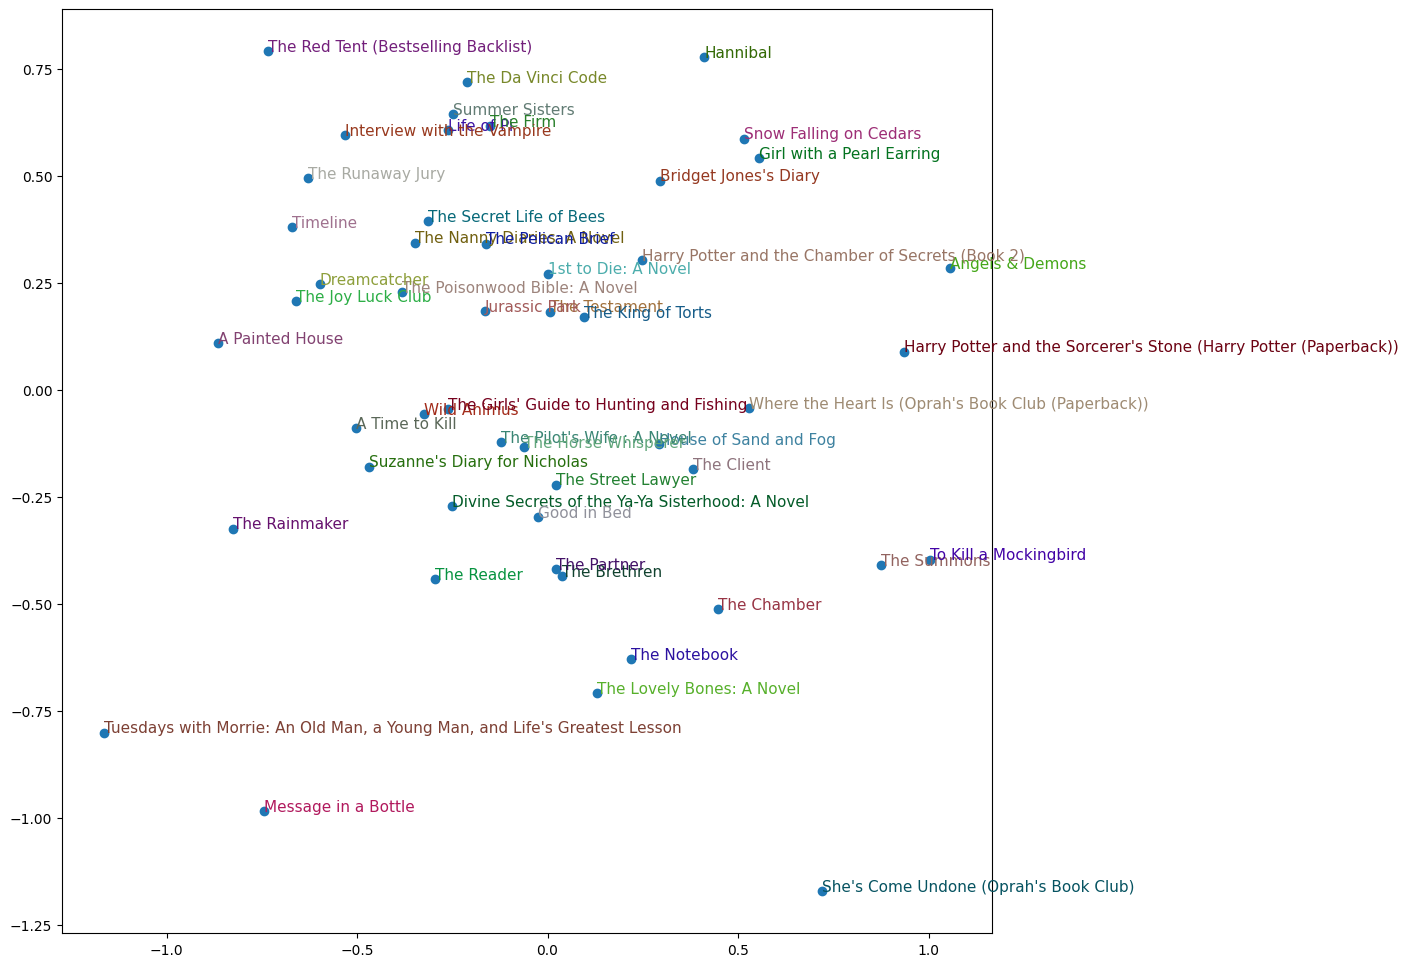

In [28]:
g = ratings.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn_dot.dls.classes['title'].o2i[m] for m in top_books])
book_w = learn_dot.model.book_factors.weight[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Criando novo usuário pra verificar recomendações feitas pra ele

O usuário foi definido por um batch do dado de teste aonde X é o ID e os livros lidos e Y a nota dada a cada livro

In [29]:
x,y = dls[0].one_batch()

Movendo todos os dados para a GPU

In [30]:
learn_dot.model.to('cuda')
x = x.to('cuda')
y = y.to('cuda')

Calculando as predições juntamente com erro médio e absoluto

In [31]:
preds = learn_dot.forward(x)
result = y-preds
error = abs(result.sum()/len(y))

error

tensor(0.2404, device='cuda:0', grad_fn=<AbsBackward0>)

Organizando os dados pra melhor visualização das previsões das notas

In [32]:
book_indices = x[:, 1]
book_list = book_indices.tolist()


book_names = [books.title[i] for i in book_list]

book_names[:10]

resultados = [f"Nome do Livro: {livro} | Nota: {nota.item()} | Previsão: {previsao.item()}" for livro, nota, previsao in zip(book_names[:10], y[:10], preds[:10])]

resultados

['Nome do Livro: Het moerastouw (Elseviers literaire serie) | Nota: 8 | Previsão: 8.035543441772461',
 'Nome do Livro: Deep Fathom | Nota: 0 | Previsão: 0.07783562690019608',
 'Nome do Livro: Super 3-Minute Thrillers | Nota: 0 | Previsão: 5.258588790893555',
 'Nome do Livro: Crossover (Star Trek The Next Generation) | Nota: 8 | Previsão: 3.1740915775299072',
 'Nome do Livro: Le Grand Voyage | Nota: 0 | Previsão: 0.2668047547340393',
 'Nome do Livro: Beyond the Threshold of Death | Nota: 0 | Previsão: 0.46333667635917664',
 'Nome do Livro: Precious in His sight | Nota: 3 | Previsão: 2.153064250946045',
 'Nome do Livro: Fair Weather | Nota: 0 | Previsão: 0.8839058876037598',
 'Nome do Livro: We Can Remember It for You Wholesale (The Collected Short Stories of Philip K. Dick, Vol. 2) | Nota: 0 | Previsão: 0.04802944138646126',
 'Nome do Livro: Blue Mirage | Nota: 0 | Previsão: 0.032441526651382446']

In [33]:
preds_deep = deep_learner.forward(x)
results = y-preds_deep
error = abs(result.sum()/len(y))
error

tensor(0.2404, device='cuda:0', grad_fn=<AbsBackward0>)

In [34]:
preds_deep[:10]

tensor([[3.6104e+00],
        [1.1608e-01],
        [3.6104e+00],
        [3.6104e+00],
        [2.4529e-01],
        [3.4193e+00],
        [3.6104e+00],
        [1.4123e+00],
        [8.4212e-02],
        [1.9983e-03]], device='cuda:0', grad_fn=<SliceBackward0>)

In [35]:
book_indices = x[:, 1]
book_list = book_indices.tolist()


book_names = [books.title[i] for i in book_list]

book_names[:10]

resultados = [f"Nome do Livro: {livro} | Nota: {nota.item()} | Previsão: {previsao.item()}" for livro, nota, previsao in zip(book_names[:10], y[:10], preds_deep[:10])]

resultados

['Nome do Livro: Het moerastouw (Elseviers literaire serie) | Nota: 8 | Previsão: 3.6103835105895996',
 'Nome do Livro: Deep Fathom | Nota: 0 | Previsão: 0.11607657372951508',
 'Nome do Livro: Super 3-Minute Thrillers | Nota: 0 | Previsão: 3.6103835105895996',
 'Nome do Livro: Crossover (Star Trek The Next Generation) | Nota: 8 | Previsão: 3.6103835105895996',
 'Nome do Livro: Le Grand Voyage | Nota: 0 | Previsão: 0.24529048800468445',
 'Nome do Livro: Beyond the Threshold of Death | Nota: 0 | Previsão: 3.4192705154418945',
 'Nome do Livro: Precious in His sight | Nota: 3 | Previsão: 3.6103835105895996',
 'Nome do Livro: Fair Weather | Nota: 0 | Previsão: 1.412301778793335',
 'Nome do Livro: We Can Remember It for You Wholesale (The Collected Short Stories of Philip K. Dick, Vol. 2) | Nota: 0 | Previsão: 0.08421240746974945',
 'Nome do Livro: Blue Mirage | Nota: 0 | Previsão: 0.0019983260426670313']

In [26]:
deep_learner.export('model.pkl')

Disponivel no huggingface no link https://huggingface.co/spaces/AlGouvea/ML_Entrega07